In [ ]:
import torch.nn as nn
import sys, os
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', '..'))

from le_pde.argparser import arg_parse
from le_pde.utils import EXP_PATH, PDE_PATH, KARMAN3D_PATH
from le_pde.pytorch_net.util import get_num_params, Printer, pload, pdump, to_np_array, filter_filename, ddeepcopy as deepcopy, init_args
from le_pde.datasets.load_dataset import load_data
import pickle
import matplotlib.pylab as plt
from le_pde.utils import parse_string_idx_to_list, parse_multi_step, get_device, update_legacy_default_hyperparam
from le_pde.models import load_model

import numpy as np
import gc
import time
p = Printer()

args = arg_parse()
args.exp_id = "user"
args.date_time = "2022-5-12"
args.dataset="karman3d"
args.n_train= "-1"
args.time_interval= 1
args.save_interval= 10
args.algo= "contrast"
args.reg_type= None
args.reg_coef= 0
args.is_reg_anneal= True
args.no_latent_evo= False
args.encoder_type= "cnn-s"
args.evolution_type= "mlp-3-elu-2"
args.decoder_type= "cnn-tr"
args.encoder_n_linear_layers= "0"
args.n_conv_blocks= 4
args.n_latent_levs= 2
args.n_conv_layers_latent= 3
args.channel_mode= "exp-16"
args.is_latent_flatten= False
args.evo_groups= 1
args.recons_coef= 1
args.consistency_coef= 1
args.contrastive_rel_coef= 0
args.hinge= 0
args.density_coef= 0.001
args.latent_noise_amp= "1e-5"
args.normalization_type= "gn"
args.latent_size= 16
args.kernel_size= 4
args.stride= 2
args.padding= 1
args.padding_mode= "zeros"
args.act_name= "elu"
args.multi_step= "1"
args.latent_multi_step= "1"
args.use_grads= False
args.use_posargs= False
args.is_y_diff= False
args.loss_type= "mse"
args.loss_type_consistency= "mse"
args.batch_size= 2
args.val_batch_size= 8
args.epochs= 52
args.opt= "adam"
args.weight_decay= 0
args.disc_coef= 0
args.seed= 0
args.gpuid= 7
args.id= 0
args.is_train=False
args.is_test_only=True
device = "cpu"

In [ ]:
def get_results_3d(all_hash, dirname, mode="best", suffix=""):
    dirname = EXP_PATH + dirname
    is_train = True
    all_dict = {}
    for hash_str in all_hash:
        filename = filter_filename(dirname, include=[hash_str, ".p"])[0]
        try:
            data_record = pload(dirname + filename)
        except Exception as e:
            p.print(filename,  banner_size=100)
            print(e)
            raise
            continue
        p.print(filename, banner_size=100)
        args = init_args(update_legacy_default_hyperparam(data_record["args"]))
        args.multi_step = "1^20"
        (dataset_train_val, dataset_test), _ = load_data(args)
        plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(data_record["epoch"], data_record["train_loss"], label="train")
        plt.plot(data_record["test_epoch"], data_record["val_loss"], label="val")
        plt.plot(data_record["test_epoch"], data_record["test_loss"], label="test")
        plt.legend()
        plt.title("learning curve")
        plt.subplot(1,2,2)
        plt.semilogy(data_record["epoch"], data_record["train_loss"], label="train")
        plt.semilogy(data_record["test_epoch"], data_record["val_loss"], label="val")
        plt.semilogy(data_record["test_epoch"], data_record["test_loss"], label="test")
        plt.legend()
        plt.title("learning curve")
        plt.show()
        all_dict[hash_str] = {key: data_record[key] for key in data_record if "loss" in key or "epoch" in key}
        pdump(all_dict, "all_dict_3d.p")

        if mode == "best":
            model = load_model(data_record["best_model_dict"], device)
            print(f"Load the model with best validation loss at epoch {data_record['best_epoch']}.")
        else:
            assert isinstance(mode, int)
            print(f'Load the model at epoch {data_record["epoch"][mode]}')
            model = load_model(data_record["model_dict"][mode], device=device)
        data_train = dataset_train_val[0]
        data_test = dataset_test[0]
        
        t = 20
        for is_train in [False, True]:
            if is_train:
                data = data_train
            else:
                data = data_test
            data.to(device)
            t_start = time.time()
            preds, info = model(
                data,
                pred_steps=[20],
                latent_pred_steps=None,
                is_recons=False,
                use_grads=False,
                is_y_diff=False,
                is_rollout=False,
            )
            t_end = time.time()
            print(t_end- t_start)
            data.to("cpu")
            preds["n0"] = preds["n0"].to("cpu")
            mask = data.mask["n0"][:,None,None]
            pred_reshape = (preds["n0"]*mask).reshape(256,128,128,4)
            y = (data.node_label["n0"]*mask)[...,t-1,:]
            y_reshape = y.reshape(256,128,128,4)
            # vmin = y_reshape.min()
            # vmax = y_reshape.max()
            all_dict[hash_str][is_train] = {}
            all_dict[hash_str][is_train]["pred"] = to_np_array(pred_reshape)
            all_dict[hash_str][is_train]["y"] = to_np_array(y_reshape)
            all_dict[hash_str][is_train]["loss_rollout"] = to_np_array(nn.MSELoss()(pred_reshape, y_reshape))

            for k in range(10,121,20):
                plt.figure(figsize=(20,8))
                plt.subplot(1,2,1)
                plt.imshow(to_np_array(pred_reshape[...,k,0]), cmap="jet", label=f"k={k}")
                plt.title(f"{hash_str}, is_train: {is_train}, loss_{t}: {all_dict[hash_str][is_train]['loss_rollout']:.6f}")
                plt.subplot(1,2,2)
                plt.title(f'best test_loss: {np.min(data_record["test_loss"]):.6f} at epoch {np.argmin(data_record["test_loss"]*args.test_interval)}')
                plt.imshow(to_np_array(y_reshape[...,k,0]),cmap="jet", label=f"k={k}")
                plt.show()
    pdump(all_dict, f"all_dict_3d{suffix}.p")

## 0. Analysis:

In [ ]:
EXP_PATH = "/dfs/project/plasma/results/"

In [ ]:
all_hash = [
    "BwCc8Bul_hyperturing1",
]
get_results_3d(all_hash, dirname="user-3d_2022-5-12/", mode="best", suffix="_3d")

## 1. Plotting:

In [113]:
mask = data.mask["n0"][:,None,None]
A = data.node_label["n0"]*mask

In [118]:
y0 = (data.node_label["n0"]*mask)[...,0,:]
y0_reshape = y0.reshape(256,128,128,1,4)

tensor(5.6966)


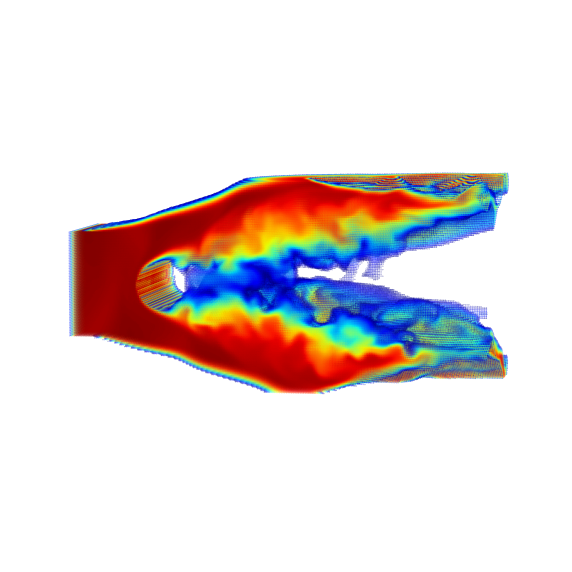

In [121]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10, 16))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('jet')
ax.set_box_aspect((2,1,1))


Z, Y, X = np.mgrid[0:256, 0:128, 0:128]

# pred10 = all_dict["ctAGpM35"]["pred"][...,0,0]
pred10 = y0_reshape[...,0,0]

k = 50
Z = Z[:,:,k:]
Y = Y[:,:,k:]
X = X[:,:,k:]
pred10 = pred10[:,:,k:]


x=X.flatten()
y=Y.flatten()
z=Z.flatten()
value=pred10.flatten()


mask = value>2.7
print(value.max())
x = x[mask,...]
y = y[mask,...]
z = z[mask,...]
value = value[mask,...]

# Creating plot
ax.scatter3D(z, x, y,
             s=0.02,
             alpha = 1,
             c = value,
             cmap = my_cmap,)
ax.view_init(5, -80)
plt.axis('off')

# plt.title("simple 3D scatter plot")
# ax.set_xlabel('Z-axis', fontweight ='bold')
# ax.set_ylabel('X-axis', fontweight ='bold')
# ax.set_zlabel('Y-axis', fontweight ='bold')
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.savefig(f"3D_y_t=0_k={k}.png", bbox_inches="tight")
# plt.savefig("3D_y_t=10.pdf", bbox_inches="tight")
plt.show()

In [ ]:
aaaaa

5.6926756


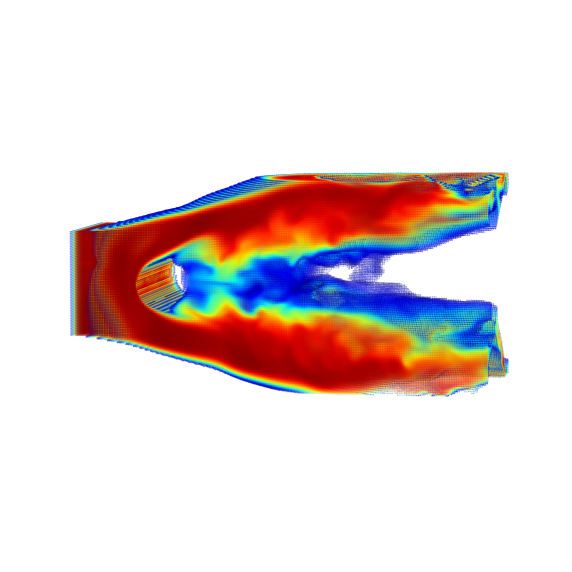

In [103]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10, 16))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('jet')
ax.set_box_aspect((2,1,1))


Z, Y, X = np.mgrid[0:256, 0:128, 0:128]

# pred10 = all_dict["ctAGpM35"]["pred"][...,0,0]
pred10 = all_dict["ctAGpM35"]["y"][...,0,0]

k = 30
Z = Z[:,:,k:]
Y = Y[:,:,k:]
X = X[:,:,k:]
pred10 = pred10[:,:,k:]


x=X.flatten()
y=Y.flatten()
z=Z.flatten()
value=pred10.flatten()


mask = value>2.7
print(value.max())
x = x[mask,...]
y = y[mask,...]
z = z[mask,...]
value = value[mask,...]

# Creating plot
ax.scatter3D(z, x, y,
             s=0.02,
             alpha = 1,
             c = value,
             cmap = my_cmap,)
ax.view_init(5, -80)
plt.axis('off')

# plt.title("simple 3D scatter plot")
# ax.set_xlabel('Z-axis', fontweight ='bold')
# ax.set_ylabel('X-axis', fontweight ='bold')
# ax.set_zlabel('Y-axis', fontweight ='bold')
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.savefig("3D_y_t=10.png", bbox_inches="tight")
# plt.savefig("3D_y_t=10.pdf", bbox_inches="tight")
plt.show()

5.7005544


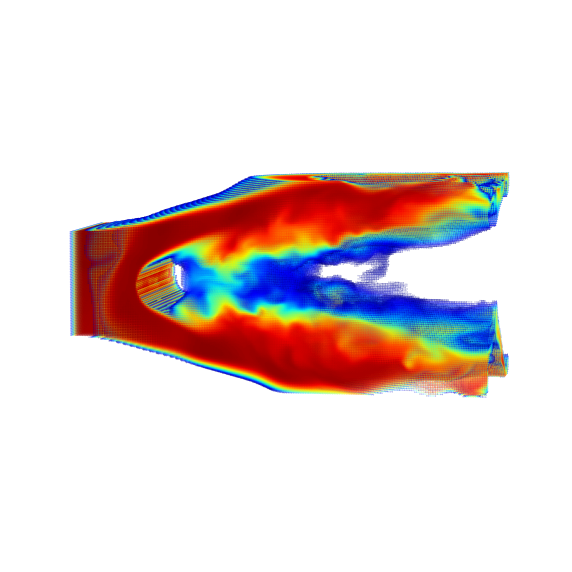

In [102]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10, 16))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('jet')
ax.set_box_aspect((2,1,1))


Z, Y, X = np.mgrid[0:256, 0:128, 0:128]

# pred10 = all_dict["ctAGpM35"]["pred"][...,0,0]
pred10 = all_dict["ctAGpM35"]["y"][...,1,0]

k = 30
Z = Z[:,:,k:]
Y = Y[:,:,k:]
X = X[:,:,k:]
pred10 = pred10[:,:,k:]


x=X.flatten()
y=Y.flatten()
z=Z.flatten()
value=pred10.flatten()


mask = value>2.7
print(value.max())
x = x[mask,...]
y = y[mask,...]
z = z[mask,...]
value = value[mask,...]

# Creating plot
ax.scatter3D(z, x, y,
             s=0.02,
             alpha = 1,
             c = value,
             cmap = my_cmap,)
ax.view_init(5, -80)
plt.axis('off')

# plt.title("simple 3D scatter plot")
# ax.set_xlabel('Z-axis', fontweight ='bold')
# ax.set_ylabel('X-axis', fontweight ='bold')
# ax.set_zlabel('Y-axis', fontweight ='bold')
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.savefig("3D_y_t=20.png", bbox_inches="tight")
# plt.savefig("3D_y_t=10.pdf", bbox_inches="tight")
plt.show()

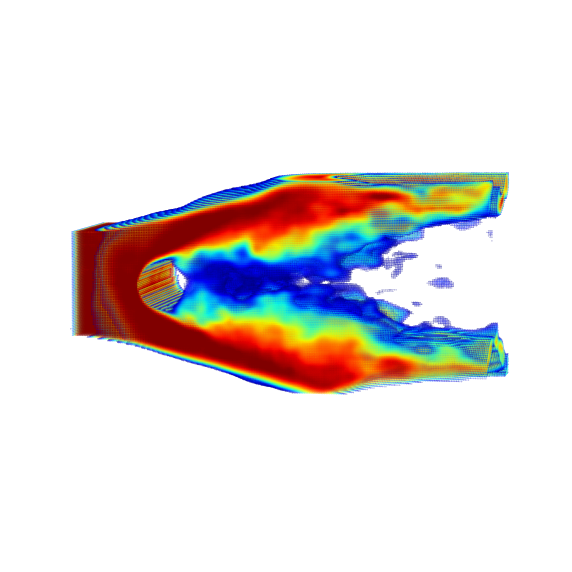

In [101]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10, 16))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('jet')
ax.set_box_aspect((2,1,1))


Z, Y, X = np.mgrid[0:256, 0:128, 0:128]

pred10 = all_dict["ctAGpM35"]["pred"][...,0,0]
# pred10 = all_dict["ctAGpM35"]["y"][...,0,0]

k = 30
Z = Z[:,:,k:]
Y = Y[:,:,k:]
X = X[:,:,k:]
pred10 = pred10[:,:,k:]


x=X.flatten()
y=Y.flatten()
z=Z.flatten()
value=pred10.flatten()
value = np.clip(value, a_min=None, a_max=5.6926)


mask = value>2.7
x = x[mask,...]
y = y[mask,...]
z = z[mask,...]
value = value[mask,...]

# Creating plot
ax.scatter3D(z, x, y,
             s=0.02,
             alpha = 1,
             c = value,
             cmap = my_cmap,)
ax.view_init(5, -80)
plt.axis('off')

# plt.title("simple 3D scatter plot")
# ax.set_xlabel('Z-axis', fontweight ='bold')
# ax.set_ylabel('X-axis', fontweight ='bold')
# ax.set_zlabel('Y-axis', fontweight ='bold')
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.savefig("3D_pred_t=10.png", bbox_inches="tight")
plt.show()

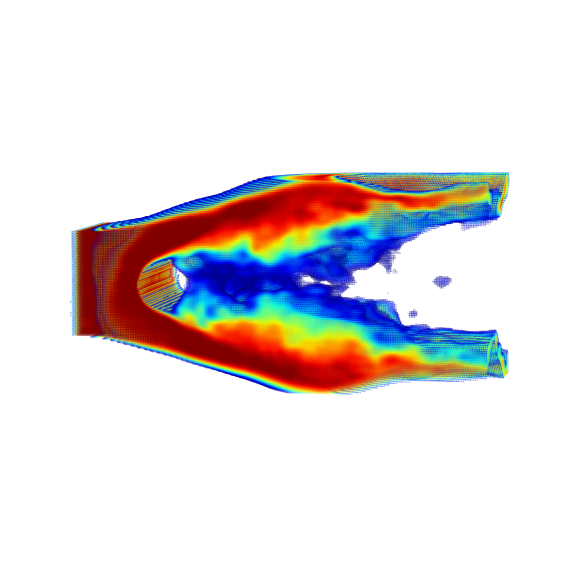

In [104]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10, 16))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('jet')
ax.set_box_aspect((2,1,1))


Z, Y, X = np.mgrid[0:256, 0:128, 0:128]

pred10 = all_dict["ctAGpM35"]["pred"][...,1,0]
# pred10 = all_dict["ctAGpM35"]["y"][...,0,0]

k = 30
Z = Z[:,:,k:]
Y = Y[:,:,k:]
X = X[:,:,k:]
pred10 = pred10[:,:,k:]


x=X.flatten()
y=Y.flatten()
z=Z.flatten()
value=pred10.flatten()
value = np.clip(value, a_min=None, a_max=5.7005544)


mask = value>2.7
x = x[mask,...]
y = y[mask,...]
z = z[mask,...]
value = value[mask,...]

# Creating plot
ax.scatter3D(z, x, y,
             s=0.02,
             alpha = 1,
             c = value,
             cmap = my_cmap,)
ax.view_init(5, -80)
plt.axis('off')

# plt.title("simple 3D scatter plot")
# ax.set_xlabel('Z-axis', fontweight ='bold')
# ax.set_ylabel('X-axis', fontweight ='bold')
# ax.set_zlabel('Y-axis', fontweight ='bold')
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.savefig("3D_pred_t=20.png", bbox_inches="tight")
plt.show()

5.6926756


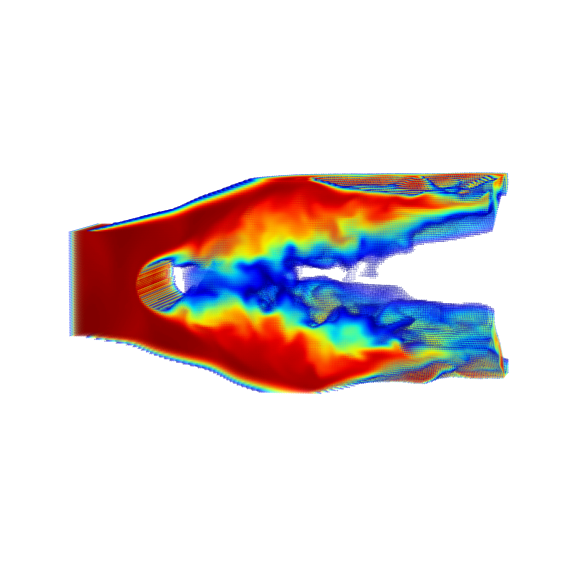

In [105]:
# k = 50, y, t=10:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10, 16))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('jet')
ax.set_box_aspect((2,1,1))


Z, Y, X = np.mgrid[0:256, 0:128, 0:128]

# pred10 = all_dict["ctAGpM35"]["pred"][...,0,0]
pred10 = all_dict["ctAGpM35"]["y"][...,0,0]

k = 50
Z = Z[:,:,k:]
Y = Y[:,:,k:]
X = X[:,:,k:]
pred10 = pred10[:,:,k:]


x=X.flatten()
y=Y.flatten()
z=Z.flatten()
value=pred10.flatten()


mask = value>2.7
print(value.max())
x = x[mask,...]
y = y[mask,...]
z = z[mask,...]
value = value[mask,...]

# Creating plot
ax.scatter3D(z, x, y,
             s=0.02,
             alpha = 1,
             c = value,
             cmap = my_cmap,)
ax.view_init(5, -80)
plt.axis('off')

# plt.title("simple 3D scatter plot")
# ax.set_xlabel('Z-axis', fontweight ='bold')
# ax.set_ylabel('X-axis', fontweight ='bold')
# ax.set_zlabel('Y-axis', fontweight ='bold')
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.savefig(f"3D_y_t=10_k={k}.png", bbox_inches="tight")
# plt.savefig("3D_y_t=10.pdf", bbox_inches="tight")
plt.show()

5.7005544


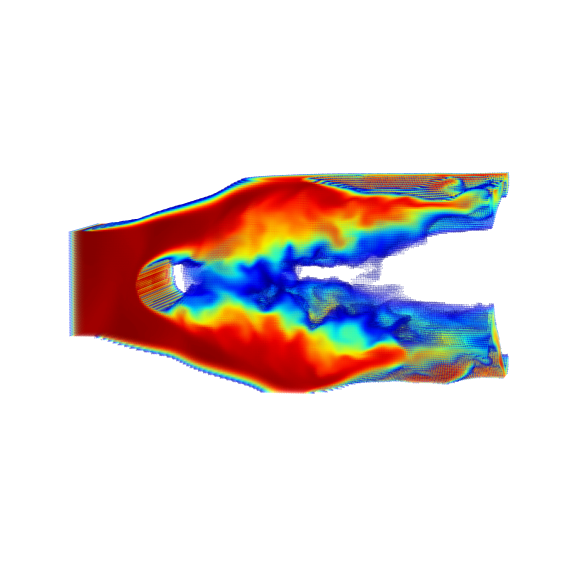

In [111]:
# k = 50, y, t=20:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10, 16))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('jet')
ax.set_box_aspect((2,1,1))


Z, Y, X = np.mgrid[0:256, 0:128, 0:128]

# pred10 = all_dict["ctAGpM35"]["pred"][...,0,0]
pred10 = all_dict["ctAGpM35"]["y"][...,1,0]

k = 50
Z = Z[:,:,k:]
Y = Y[:,:,k:]
X = X[:,:,k:]
pred10 = pred10[:,:,k:]


x=X.flatten()
y=Y.flatten()
z=Z.flatten()
value=pred10.flatten()


mask = value>2.7
print(value.max())
x = x[mask,...]
y = y[mask,...]
z = z[mask,...]
value = value[mask,...]

# Creating plot
ax.scatter3D(z, x, y,
             s=0.02,
             alpha = 1,
             c = value,
             cmap = my_cmap,)
ax.view_init(5, -80)
plt.axis('off')

# plt.title("simple 3D scatter plot")
# ax.set_xlabel('Z-axis', fontweight ='bold')
# ax.set_ylabel('X-axis', fontweight ='bold')
# ax.set_zlabel('Y-axis', fontweight ='bold')
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.savefig(f"3D_y_t=20_k={k}.png", bbox_inches="tight")
# plt.savefig("3D_y_t=10.pdf", bbox_inches="tight")
plt.show()

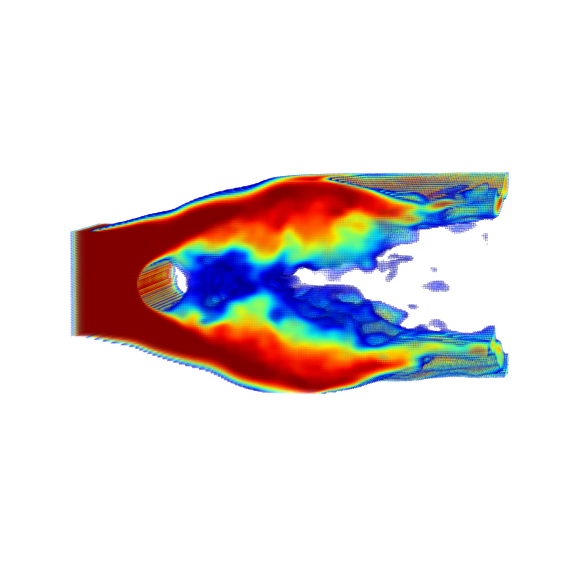

In [110]:
# k = 50, pred, t=10:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10, 16))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('jet')
ax.set_box_aspect((2,1,1))


Z, Y, X = np.mgrid[0:256, 0:128, 0:128]

pred10 = all_dict["ctAGpM35"]["pred"][...,0,0]
# pred10 = all_dict["ctAGpM35"]["y"][...,0,0]

k = 50
Z = Z[:,:,k:]
Y = Y[:,:,k:]
X = X[:,:,k:]
pred10 = pred10[:,:,k:]


x=X.flatten()
y=Y.flatten()
z=Z.flatten()
value=pred10.flatten()
value = np.clip(value, a_min=None, a_max=5.6926)


mask = value>2.7
x = x[mask,...]
y = y[mask,...]
z = z[mask,...]
value = value[mask,...]

# Creating plot
ax.scatter3D(z, x, y,
             s=0.02,
             alpha = 1,
             c = value,
             cmap = my_cmap,)
ax.view_init(5, -80)
plt.axis('off')

# plt.title("simple 3D scatter plot")
# ax.set_xlabel('Z-axis', fontweight ='bold')
# ax.set_ylabel('X-axis', fontweight ='bold')
# ax.set_zlabel('Y-axis', fontweight ='bold')
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.savefig(f"3D_pred_t=10_k={k}.png", bbox_inches="tight")
plt.show()

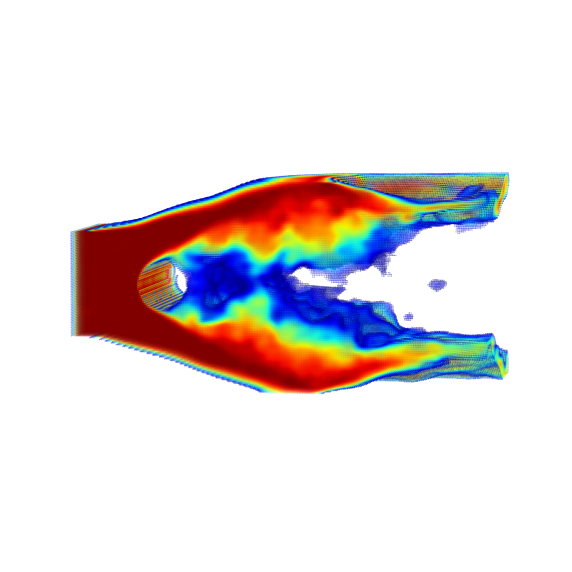

In [109]:
# k = 50, pred, t=20:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10, 16))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('jet')
ax.set_box_aspect((2,1,1))


Z, Y, X = np.mgrid[0:256, 0:128, 0:128]

pred10 = all_dict["ctAGpM35"]["pred"][...,1,0]
# pred10 = all_dict["ctAGpM35"]["y"][...,0,0]

k = 50
Z = Z[:,:,k:]
Y = Y[:,:,k:]
X = X[:,:,k:]
pred10 = pred10[:,:,k:]


x=X.flatten()
y=Y.flatten()
z=Z.flatten()
value=pred10.flatten()
value = np.clip(value, a_min=None, a_max=5.7005544)


mask = value>2.7
x = x[mask,...]
y = y[mask,...]
z = z[mask,...]
value = value[mask,...]

# Creating plot
ax.scatter3D(z, x, y,
             s=0.02,
             alpha = 1,
             c = value,
             cmap = my_cmap,)
ax.view_init(5, -80)
plt.axis('off')

# plt.title("simple 3D scatter plot")
# ax.set_xlabel('Z-axis', fontweight ='bold')
# ax.set_ylabel('X-axis', fontweight ='bold')
# ax.set_zlabel('Y-axis', fontweight ='bold')
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.savefig(f"3D_pred_t=20_k={k}.png", bbox_inches="tight")
plt.show()